In [171]:
import sys
print(sys.executable)

/Users/martacaninoromero/DarkMatter_ML_TFG/.venv/bin/python


In [172]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

In [173]:

fname = "tables/catalog_data_4FGL_DR4.h5"

with h5py.File(fname, "r") as f:
    # read attributes
    E0 = f.attrs["E0"]
    
    # read assoc data (fuentes conocidas - datos de entrenamiento)
    alpha_as = f["assoc"]["alpha"][:]
    beta_as = f["assoc"]["beta"][:]
    flux_as = f["assoc"]["flux"][:]
    
    # read unassoc data (candidatos a materia oscura)
    alpha_unas = f["unas"]["alpha"][:]
    beta_unas = f["unas"]["beta"][:]
    flux_unas = f["unas"]["flux"][:]

In [174]:
print('E0 (energy): attribute value', E0)
print('UNAS - alpha, beta & flux shape: ', alpha_unas.shape, beta_unas.shape, flux_unas.shape)
print('AS - alpha, beta & flux shape: ', alpha_as.shape, beta_as.shape, flux_as.shape)

E0 (energy): attribute value 1000
UNAS - alpha, beta & flux shape:  (1284,) (1284,) (1284,)
AS - alpha, beta & flux shape:  (3784,) (3784,) (3784,)


In [175]:

# Convert to pandas DataFrame
df_as = pd.DataFrame({
    'alpha': alpha_as,
    'beta': beta_as,
    'flux': flux_as
})

df_unas = pd.DataFrame({
    'alpha': alpha_unas,
    'beta': beta_unas,
    'flux': flux_unas
})

print(f"Datos cargados exitosamente:")
print(f"- Fuentes asociadas (entrenamiento): {len(df_as)}")
print(f"- Fuentes no asociadas (predicción): {len(df_unas)}")
print(f"- Energía de referencia E0: {E0}")

Datos cargados exitosamente:
- Fuentes asociadas (entrenamiento): 3784
- Fuentes no asociadas (predicción): 1284
- Energía de referencia E0: 1000


In [176]:
# Double check the data conversion
df_as.shape[0] == len(alpha_as)
df_unas.shape[0] == len(alpha_unas)

True

In [177]:
print(df_as.shape)
df_as.head()

(3784, 3)


,alpha,beta,flux
0,1.997826,0.049796,-8.922482
1,1.997502,0.037899,-8.018044
2,2.139592,-0.010222,-8.599896
3,2.865929,0.148901,-7.261064
4,1.338169,0.120901,-8.971793


In [178]:
print(df_unas.shape)
df_unas.head()

(1284, 3)


,alpha,beta,flux
0,1.984765,0.109999,-9.250384
1,2.176364,0.109660,-8.828196
2,0.902878,0.251122,-10.038708
3,2.098364,0.324241,-8.781500
4,2.086239,0.333186,-8.672857


In [179]:
print('Associated sources: ')
df_as.describe()

Associated sources: 


,alpha,beta,flux
count,3784.000000,3784.000000,3784.000000
mean,2.016049,0.119914,-8.467080
std,0.587186,0.122898,0.643259
min,-1.254197,-0.128125,-10.543907
25%,1.714093,0.040843,-8.843178
50%,2.092988,0.092526,-8.413159
75%,2.410078,0.164627,-8.070424
max,4.463546,0.796040,-6.154286


In [180]:
print('\nUnassociated sources:')
df_unas.describe()


Unassociated sources:


,alpha,beta,flux
count,1284.000000,1284.000000,1284.000000
mean,2.024184,0.182429,-8.746101
std,0.732372,0.165423,0.558917
min,-1.775794,-0.111614,-10.835591
25%,1.651657,0.054358,-9.102418
50%,2.142563,0.153545,-8.642136
75%,2.495624,0.300316,-8.335582
max,4.036645,0.746194,-7.366050


In [181]:
print("\nEstadísticas descriptivas - Fuentes Asociadas:")
print(df_as.describe())

print("\nEstadísticas descriptivas - Fuentes No Asociadas:")
print(df_unas.describe())

# Verificar calidad de datos
print(f"\nCalidad de datos:")
print(f"- Valores nulos en asociadas: {df_as.isnull().sum().sum()}")
print(f"- Valores nulos en no asociadas: {df_unas.isnull().sum().sum()}")
print(f"- Valores infinitos en asociadas: {np.isinf(df_as.values).sum()}")
print(f"- Valores infinitos en no asociadas: {np.isinf(df_unas.values).sum()}")


Estadísticas descriptivas - Fuentes Asociadas:
             alpha         beta         flux
count  3784.000000  3784.000000  3784.000000
mean      2.016049     0.119914    -8.467080
std       0.587186     0.122898     0.643259
min      -1.254197    -0.128125   -10.543907
25%       1.714093     0.040843    -8.843178
50%       2.092988     0.092526    -8.413159
75%       2.410078     0.164627    -8.070424
max       4.463546     0.796040    -6.154286

Estadísticas descriptivas - Fuentes No Asociadas:
             alpha         beta         flux
count  1284.000000  1284.000000  1284.000000
mean      2.024184     0.182429    -8.746101
std       0.732372     0.165423     0.558917
min      -1.775794    -0.111614   -10.835591
25%       1.651657     0.054358    -9.102418
50%       2.142563     0.153545    -8.642136
75%       2.495624     0.300316    -8.335582
max       4.036645     0.746194    -7.366050

Calidad de datos:
- Valores nulos en asociadas: 0
- Valores nulos en no asociadas: 0
- Val

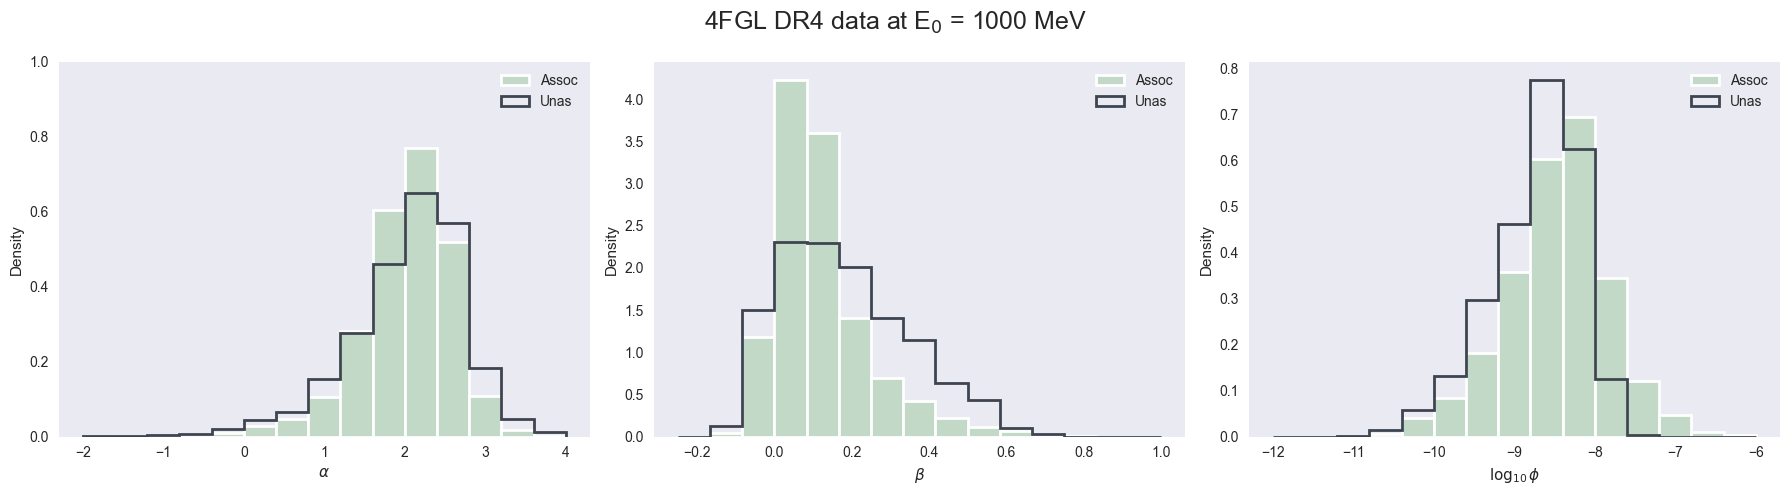

In [182]:
# Plot the data the same way to check the distributions
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

nbins = 15
unas_color = "#3e4550"
as_color = "#c2d9c7"

fig.suptitle(r"4FGL DR4 data at E$_0$ = {:.0f} MeV".format(E0), fontsize=18)

# Alpha
axs[0].hist(df_as['alpha'], bins=nbins, range=[-2, 4], color=as_color, edgecolor="white", lw=2, density=True, label="Assoc")
axs[0].hist(df_unas['alpha'], bins=nbins, range=[-2, 4], histtype='step', edgecolor=unas_color, lw=2, density=True, label="Unas")
axs[0].set_xlabel(r"$\alpha$")
axs[0].set_ylabel("Density")
axs[0].legend()
axs[0].grid(0)
axs[0].set_ylim(0, 1.0)

# Beta
axs[1].hist(df_as['beta'], bins=nbins, range=[-0.25, 1.0], color=as_color, edgecolor="white", lw=2, density=True, label="Assoc")
axs[1].hist(df_unas['beta'], bins=nbins, range=[-0.25, 1.0], histtype='step', edgecolor=unas_color, lw=2, density=True, label="Unas")
axs[1].set_xlabel(r"$\beta$")
axs[1].set_ylabel("Density")
axs[1].legend()
axs[1].grid(0)

# Flux
axs[2].hist(df_as['flux'], bins=nbins, range=[-12, -6], color=as_color, edgecolor="white", lw=2, density=True, label="Assoc")
axs[2].hist(df_unas['flux'], bins=nbins, range=[-12, -6], histtype='step', edgecolor=unas_color, lw=2, density=True, label="Unas")
axs[2].set_xlabel(r"$\log_{10} \phi$")
axs[2].set_ylabel("Density")
axs[2].legend()
axs[2].grid(0)

plt.tight_layout()
plt.show()

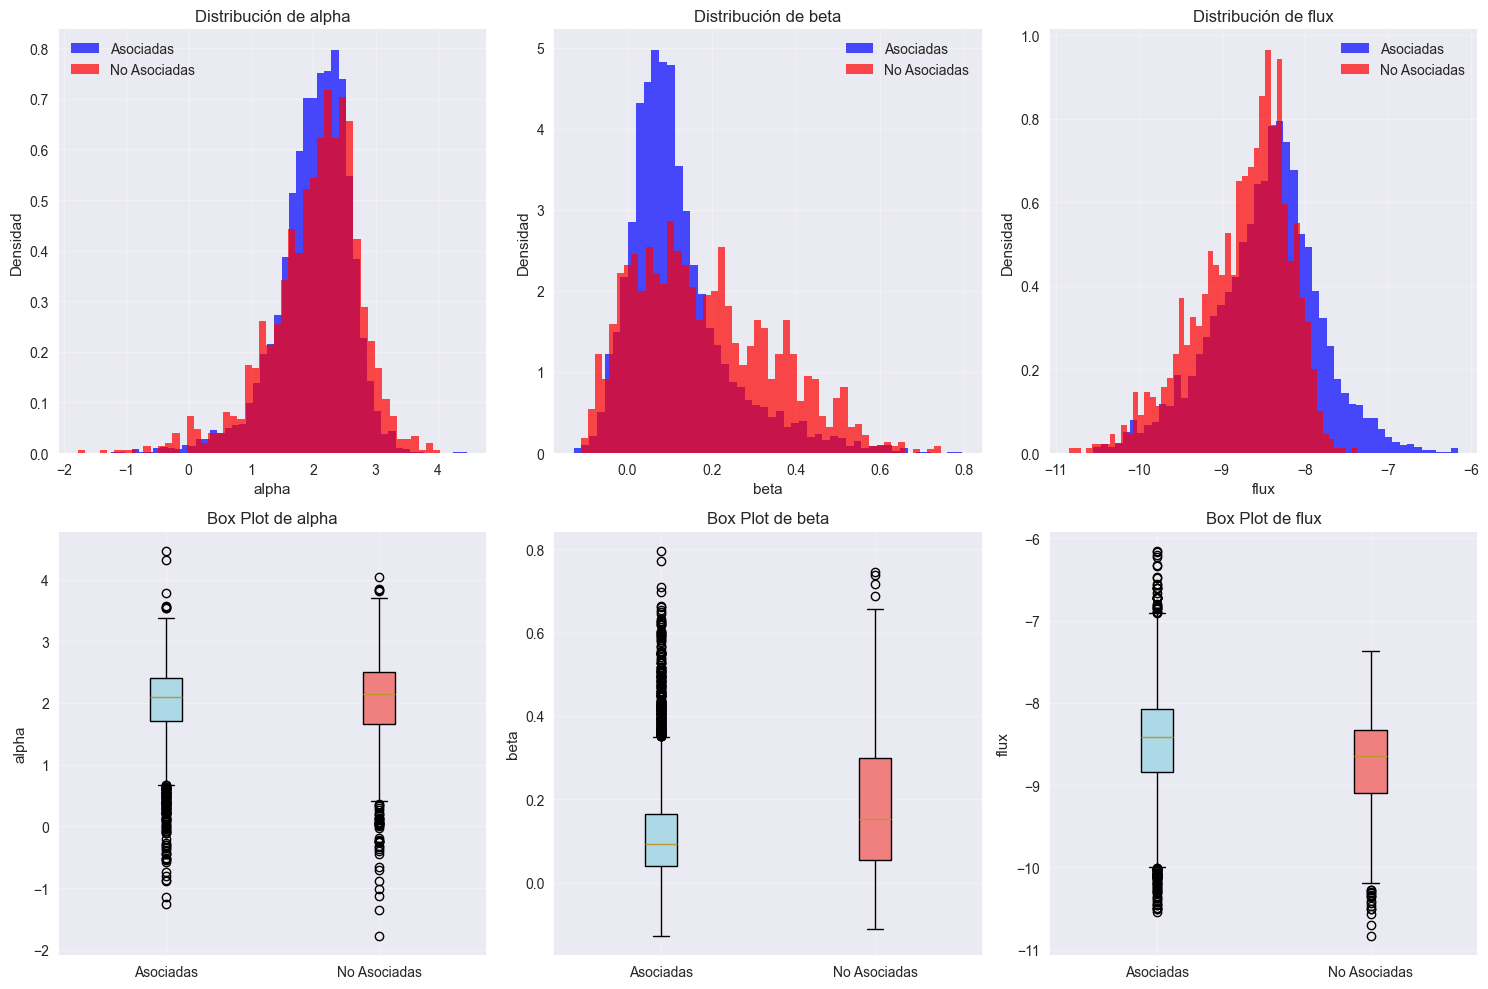

In [183]:
# Visualización de distribuciones
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

features = ['alpha', 'beta', 'flux']
for i, feature in enumerate(features):
    # Histogramas comparativos
    axes[0, i].hist(df_as[feature], bins=50, alpha=0.7, label='Asociadas', density=True, color='blue')
    axes[0, i].hist(df_unas[feature], bins=50, alpha=0.7, label='No Asociadas', density=True, color='red')
    axes[0, i].set_xlabel(feature)
    axes[0, i].set_ylabel('Densidad')
    axes[0, i].legend()
    axes[0, i].set_title(f'Distribución de {feature}')
    axes[0, i].grid(True, alpha=0.3)
    
    
    # Box plots comparativos
    data_to_plot = [df_as[feature], df_unas[feature]]
    box_plot = axes[1, i].boxplot(data_to_plot, labels=['Asociadas', 'No Asociadas'], patch_artist=True)
    box_plot['boxes'][0].set_facecolor('lightblue')
    box_plot['boxes'][1].set_facecolor('lightcoral')
    axes[1, i].set_ylabel(feature)
    axes[1, i].set_title(f'Box Plot de {feature}')
    axes[1, i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## PREPROCESAMIENTO DE DATOS

In [184]:

# Seleccionar features
features = ['alpha', 'beta', 'flux']
X = df_as[features].values

In [185]:
# Limpiar datos: remover infinitos y NaN
print(f"Datos originales: {X.shape[0]} muestras")
mask = np.isfinite(X).all(axis=1)
X_clean = X[mask]
print(f"Datos después de limpiar infinitos/NaN: {X_clean.shape[0]} muestras")
print(f"Muestras quitadas: {X.shape[0] - X_clean.shape[0]}")

Datos originales: 3784 muestras
Datos después de limpiar infinitos/NaN: 3784 muestras
Muestras quitadas: 0


In [186]:

# División de datos
X_train, X_temp = train_test_split(X_clean, test_size=0.4, random_state=42)
X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=42)


print(f"\nDivisión de datos:")
print(f"- Entrenamiento: {X_train.shape[0]} muestras ({X_train.shape[0]/X_clean.shape[0]*100:.1f}%)")
print(f"- Validación: {X_val.shape[0]} muestras ({X_val.shape[0]/X_clean.shape[0]*100:.1f}%)")
print(f"- Test: {X_test.shape[0]} muestras ({X_test.shape[0]/X_clean.shape[0]*100:.1f}%)")


División de datos:
- Entrenamiento: 2270 muestras (60.0%)
- Validación: 757 muestras (20.0%)
- Test: 757 muestras (20.0%)


In [187]:
# Escalado de datos - usando RobustScaler para mayor robustez ante outliers
scaler = RobustScaler()  # Menos sensible a outliers que StandardScaler
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"\nEscalado completado usando RobustScaler")
print(f"Estadísticas de datos escalados (train):")
print(f"- Media: {np.mean(X_train_scaled, axis=0)}")
print(f"- Std: {np.std(X_train_scaled, axis=0)}")


Escalado completado usando RobustScaler
Estadísticas de datos escalados (train):
- Media: [-0.11380152  0.20374289 -0.06228386]
- Std: [0.8306246 0.9629394 0.8004226]


# Train the model - 3F OneClassSVM

In [188]:

# Grid de hiperparámetros ampliado
nu_values = [0.001, 0.005, 0.01, 0.02, 0.05, 0.1]
gamma_values = ['scale', 'auto'] + list(np.logspace(-4, 1, 8))

print(f"Probando {len(nu_values)} valores de nu y {len(gamma_values)} valores de gamma")
print(f"Total de combinaciones: {len(nu_values) * len(gamma_values)}")

best_model = None
best_params = {}
best_score = np.inf
results = []

total_combinations = len(nu_values) * len(gamma_values)
current_combination = 0

for nu in nu_values:
    for gamma in gamma_values:
        current_combination += 1
        
        # Mostrar progreso cada 10 iteraciones
        if current_combination % 10 == 0 or current_combination == total_combinations:
            print(f"Progreso: {current_combination}/{total_combinations} ({current_combination/total_combinations*100:.1f}%)")
        
        model = OneClassSVM(kernel='rbf', nu=nu, gamma=gamma)
        model.fit(X_train_scaled)
        
        # Predicciones en validación
        preds_val = model.predict(X_val_scaled)
        decision_scores = model.decision_function(X_val_scaled)
        
        # Métricas detalladas
        n_outliers = np.sum(preds_val == -1)
        outlier_ratio = n_outliers / len(preds_val)
        mean_score = np.mean(decision_scores)
        std_score = np.std(decision_scores)
        
        results.append({
            'nu': nu, 
            'gamma': gamma, 
            'outliers': n_outliers,
            'outlier_ratio': outlier_ratio,
            'mean_score': mean_score,
            'std_score': std_score
        })
        
        # Criterio de selección mejorado
        target_ratio = nu  # nu aproxima el ratio esperado de outliers
        ratio_penalty = abs(outlier_ratio - target_ratio)
        score_quality = abs(mean_score)  # Preferimos scores más extremos
        combined_score = ratio_penalty + (1 - score_quality) / 10
        
        if combined_score < best_score:
            best_score = combined_score
            best_model = model
            best_params = {'nu': nu, 'gamma': gamma}

# Convertir resultados a DataFrame para análisis
results_df = pd.DataFrame(results)

Probando 6 valores de nu y 10 valores de gamma
Total de combinaciones: 60
Progreso: 10/60 (16.7%)
Progreso: 20/60 (33.3%)
Progreso: 30/60 (50.0%)
Progreso: 40/60 (66.7%)
Progreso: 50/60 (83.3%)
Progreso: 60/60 (100.0%)


In [189]:
print(f"\nMEJORES PARÁMETROS ENCONTRADOS")
print(f"Nu: {best_params['nu']}")
print(f"Gamma: {best_params['gamma']}")

# Mostrar estadísticas del mejor modelo
best_result = results_df[(results_df['nu'] == best_params['nu']) & 
                        (results_df['gamma'] == best_params['gamma'])].iloc[0]

print(f"\nEstadísticas del mejor modelo en validación:")
print(f"- Outliers detectados: {best_result['outliers']} ({best_result['outlier_ratio']*100:.2f}%)")
print(f"- Score promedio: {best_result['mean_score']:.4f} ± {best_result['std_score']:.4f}")



MEJORES PARÁMETROS ENCONTRADOS
Nu: 0.1
Gamma: 0.07196856730011521

Estadísticas del mejor modelo en validación:
- Outliers detectados: 90 (11.89%)
- Score promedio: 10.1416 ± 10.4204


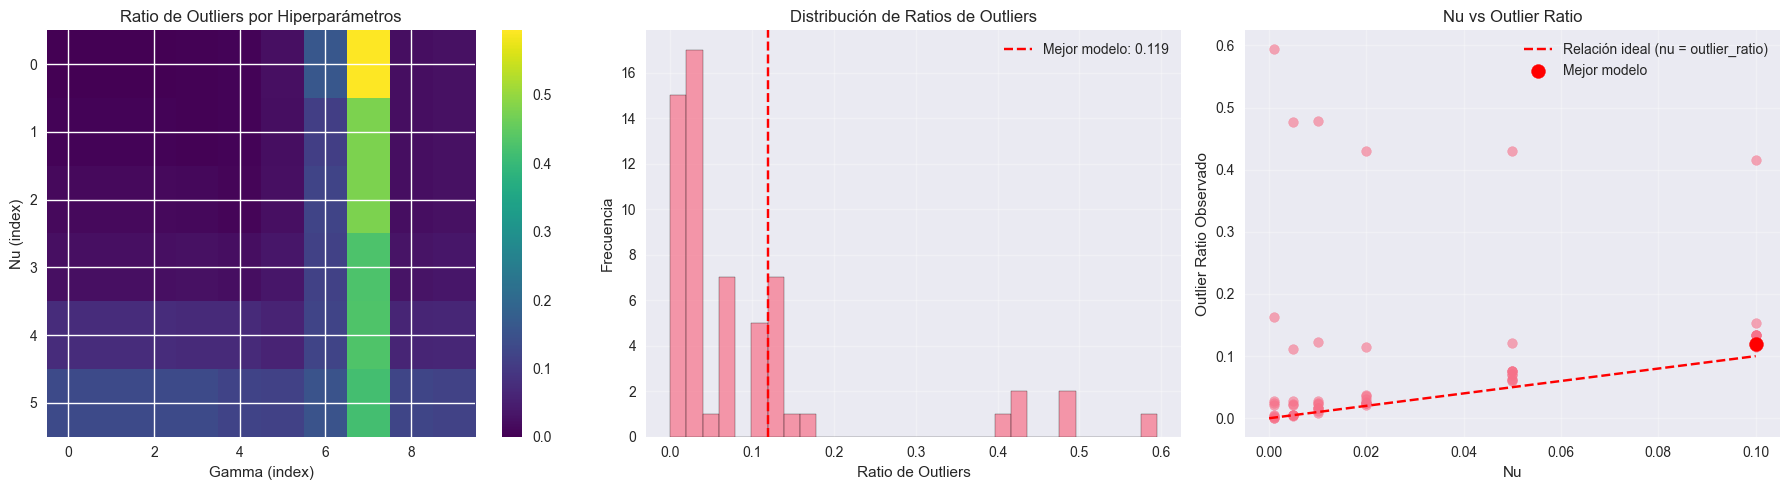

In [190]:
# Visualización de la búsqueda de hiperparámetros
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Heatmap de outlier ratio
pivot_outliers = results_df.pivot(index='nu', columns='gamma', values='outlier_ratio')
im1 = axes[0].imshow(pivot_outliers.values, aspect='auto', cmap='viridis')
axes[0].set_title('Ratio de Outliers por Hiperparámetros')
axes[0].set_xlabel('Gamma (index)')
axes[0].set_ylabel('Nu (index)')
plt.colorbar(im1, ax=axes[0])

# Distribución de ratios de outliers
axes[1].hist(results_df['outlier_ratio'], bins=30, alpha=0.7, edgecolor='black')
axes[1].axvline(best_result['outlier_ratio'], color='red', linestyle='--', 
                label=f'Mejor modelo: {best_result["outlier_ratio"]:.3f}')
axes[1].set_xlabel('Ratio de Outliers')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title('Distribución de Ratios de Outliers')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Relación entre nu y outlier ratio
axes[2].scatter(results_df['nu'], results_df['outlier_ratio'], alpha=0.6)
axes[2].plot([0, 0.1], [0, 0.1], 'r--', label='Relación ideal (nu = outlier_ratio)')
axes[2].scatter(best_params['nu'], best_result['outlier_ratio'], 
                color='red', s=100, label='Mejor modelo', zorder=5)
axes[2].set_xlabel('Nu')
axes[2].set_ylabel('Outlier Ratio Observado')
axes[2].set_title('Nu vs Outlier Ratio')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [191]:

# Entrenamiento final del modelo con los mejores hiperparámetros
final_model = OneClassSVM(kernel='rbf', nu=best_params['nu'], gamma=best_params['gamma'])
final_model.fit(X_train_scaled)

OneClassSVM(gamma=np.float64(0.07196856730011521), nu=0.1)

In [192]:
# Predicciones en test
test_preds = final_model.predict(X_test_scaled)
test_scores = final_model.decision_function(X_test_scaled)

# Estadísticas básicas
n_inliers_test = np.sum(test_preds == 1)
n_outliers_test = np.sum(test_preds == -1)

print(f"Resultados en datos de test:")
print(f"- Inliers: {n_inliers_test} ({n_inliers_test/len(test_preds)*100:.2f}%)")
print(f"- Outliers: {n_outliers_test} ({n_outliers_test/len(test_preds)*100:.2f}%)")
print(f"- Score promedio: {np.mean(test_scores):.4f} ± {np.std(test_scores):.4f}")
print(f"- Score mínimo: {np.min(test_scores):.4f}")
print(f"- Score máximo: {np.max(test_scores):.4f}")

"""
# Análisis por cuartiles
quartiles = np.percentile(test_scores, [25, 50, 75])
print(f"\nCuartiles de scores:")
print(f"- Q1 (25%): {quartiles[0]:.4f}")
print(f"- Q2 (50%): {quartiles[1]:.4f}")
print(f"- Q3 (75%): {quartiles[2]:.4f}")"""

Resultados en datos de test:
- Inliers: 661 (87.32%)
- Outliers: 96 (12.68%)
- Score promedio: 10.2760 ± 10.9135
- Score mínimo: -60.1210
- Score máximo: 24.7566


'\n# Análisis por cuartiles\nquartiles = np.percentile(test_scores, [25, 50, 75])\nprint(f"\nCuartiles de scores:")\nprint(f"- Q1 (25%): {quartiles[0]:.4f}")\nprint(f"- Q2 (50%): {quartiles[1]:.4f}")\nprint(f"- Q3 (75%): {quartiles[2]:.4f}")'

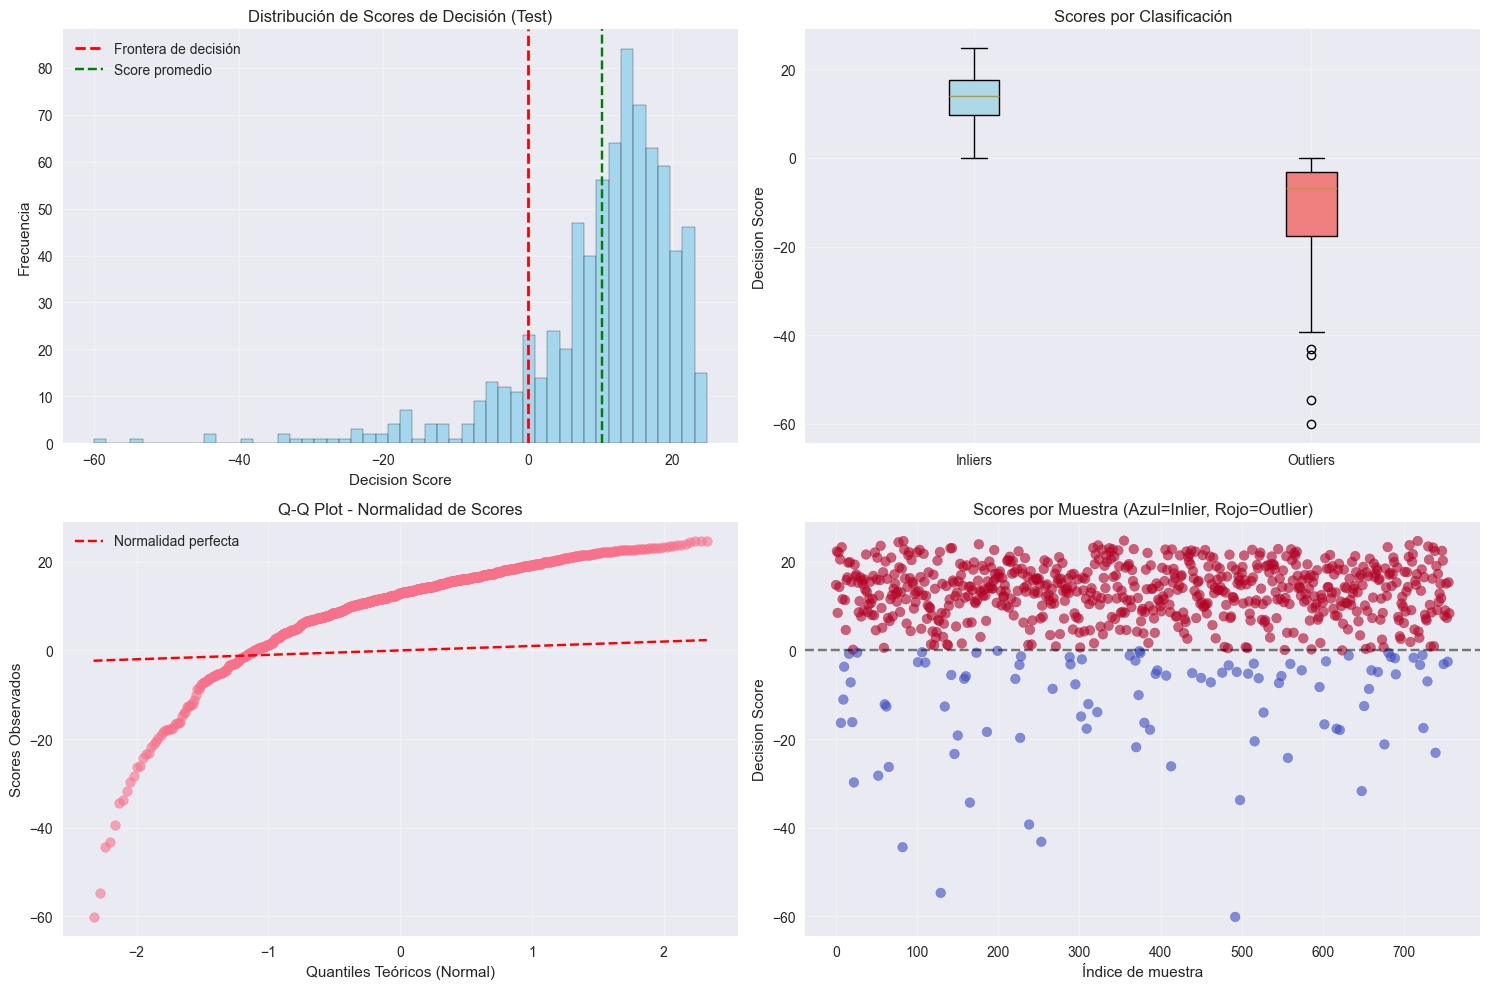

In [193]:
# Análisis visual de la evaluación
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribución de scores de decisión
axes[0,0].hist(test_scores, bins=50, alpha=0.7, edgecolor='black', color='skyblue')
axes[0,0].axvline(0, color='red', linestyle='--', linewidth=2, label='Frontera de decisión')
axes[0,0].axvline(np.mean(test_scores), color='green', linestyle='--', label='Score promedio')
axes[0,0].set_xlabel('Decision Score')
axes[0,0].set_ylabel('Frecuencia')
axes[0,0].set_title('Distribución de Scores de Decisión (Test)')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Comparación de scores por clasificación
inlier_scores = test_scores[test_preds == 1]
outlier_scores = test_scores[test_preds == -1]

box_data = [inlier_scores, outlier_scores]
box_plot = axes[0,1].boxplot(box_data, labels=['Inliers', 'Outliers'], patch_artist=True)
box_plot['boxes'][0].set_facecolor('lightblue')
box_plot['boxes'][1].set_facecolor('lightcoral')
axes[0,1].set_ylabel('Decision Score')
axes[0,1].set_title('Scores por Clasificación')
axes[0,1].grid(True, alpha=0.3)

# Q-Q plot para normalidad
from scipy import stats
sorted_scores = np.sort(test_scores)
theoretical_quantiles = stats.norm.ppf(np.linspace(0.01, 0.99, len(sorted_scores)))
axes[1,0].scatter(theoretical_quantiles, sorted_scores, alpha=0.6)
axes[1,0].plot(theoretical_quantiles, theoretical_quantiles, 'r--', label='Normalidad perfecta')
axes[1,0].set_xlabel('Quantiles Teóricos (Normal)')
axes[1,0].set_ylabel('Scores Observados')
axes[1,0].set_title('Q-Q Plot - Normalidad de Scores')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Scatter plot de scores vs índices
axes[1,1].scatter(range(len(test_scores)), test_scores, 
                  c=test_preds, cmap='coolwarm', alpha=0.6)
axes[1,1].axhline(0, color='black', linestyle='--', alpha=0.5)
axes[1,1].set_xlabel('Índice de muestra')
axes[1,1].set_ylabel('Decision Score')
axes[1,1].set_title('Scores por Muestra (Azul=Inlier, Rojo=Outlier)')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Predecir sobre unassociated data (unas)

In [194]:
# Preparar datos de fuentes no asociadas
features = ['alpha', 'beta', 'flux']
X_unas = df_unas[features].values

print(f"Fuentes no asociadas originales: {len(X_unas)}")


Fuentes no asociadas originales: 1284


In [195]:
# Limpiar datos no asociados
mask_unas = np.isfinite(X_unas).all(axis=1)
X_unas_clean = X_unas[mask_unas]
clean_indices = np.where(mask_unas)[0]

print(f"Fuentes no asociadas válidas: {len(X_unas_clean)}")
print(f"Fuentes quitadas por datos inválidos: {len(X_unas) - len(X_unas_clean)}")

Fuentes no asociadas válidas: 1284
Fuentes quitadas por datos inválidos: 0


In [196]:
# Escalar datos usando el mismo scaler del entrenamiento
X_unas_scaled = scaler.transform(X_unas_clean)

# Realizar predicciones
unas_preds = final_model.predict(X_unas_scaled)
unas_scores = final_model.decision_function(X_unas_scaled)

In [197]:
# get predictions + decision scores
preds = best_model.predict(X_val_scaled)
decision_scores = best_model.decision_function(X_val_scaled)

# index maxs
inlier_idx = preds == 1
outlier_idx = preds == -1

In [198]:
# Análisis de resultados
n_normal = np.sum(unas_preds == 1)
n_anomalous = np.sum(unas_preds == -1)

print(f"\nResultados en fuentes no asociadas:")
print(f"- Fuentes normales: {n_normal} ({n_normal/len(unas_preds)*100:.2f}%)")
print(f"- Candidatos anómalos: {n_anomalous} ({n_anomalous/len(unas_preds)*100:.2f}%)")

# Estadísticas de scores
print(f"\nEstadísticas de scores de anomalía:")
print(f"- Score promedio: {np.mean(unas_scores):.4f} ± {np.std(unas_scores):.4f}")
print(f"- Score más anómalo: {np.min(unas_scores):.4f}")
print(f"- Score menos anómalo: {np.max(unas_scores):.4f}")



Resultados en fuentes no asociadas:
- Fuentes normales: 1014 (78.97%)
- Candidatos anómalos: 270 (21.03%)

Estadísticas de scores de anomalía:
- Score promedio: 7.6238 ± 13.4625
- Score más anómalo: -77.6622
- Score menos anómalo: 24.9705


## Análisis de candidatos

In [199]:
# Crear DataFrame con resultados completos
results_unas = df_unas.iloc[clean_indices].copy()
results_unas['prediction'] = unas_preds
results_unas['anomaly_score'] = unas_scores
results_unas['is_candidate'] = unas_preds == -1

# Filtrar candidatos anómalos
candidates = results_unas[results_unas['is_candidate']].copy()
candidates_sorted = candidates.sort_values('anomaly_score').reset_index(drop=True)

print(f"ANÁLISIS DE CANDIDATOS A MATERIA OSCURA")
print(f"Total de candidatos encontrados: {len(candidates)}")

if len(candidates) > 0:
    print(f"\nCaracterísticas de los candidatos:")
    print(f"- Alpha promedio: {candidates['alpha'].mean():.4f} ± {candidates['alpha'].std():.4f}")
    print(f"- Beta promedio: {candidates['beta'].mean():.4f} ± {candidates['beta'].std():.4f}")
    print(f"- Flux promedio: {candidates['flux'].mean():.2e} ± {candidates['flux'].std():.2e}")
    print(f"- Score de anomalía promedio: {candidates['anomaly_score'].mean():.4f}")
    
    print(f"\nTop 10 candidatos más anómalos:")
    top_candidates = candidates_sorted[['alpha', 'beta', 'flux', 'anomaly_score']].head(10)
    print(top_candidates.to_string(index=True, float_format='%.4f'))
    
    print(f"\nComparación con fuentes asociadas:")
    print(f"- Alpha: Candidatos={candidates['alpha'].mean():.4f}, Asociadas={df_as['alpha'].mean():.4f}")
    print(f"- Beta: Candidatos={candidates['beta'].mean():.4f}, Asociadas={df_as['beta'].mean():.4f}")
    print(f"- Flux: Candidatos={candidates['flux'].mean():.2e}, Asociadas={df_as['flux'].mean():.2e}")


ANÁLISIS DE CANDIDATOS A MATERIA OSCURA
Total de candidatos encontrados: 270

Características de los candidatos:
- Alpha promedio: 1.8571 ± 1.2177
- Beta promedio: 0.2769 ± 0.2434
- Flux promedio: -8.95e+00 ± 7.56e-01
- Score de anomalía promedio: -12.8132

Top 10 candidatos más anómalos:
    alpha   beta     flux  anomaly_score
0 -1.7758 0.4474 -10.7053       -77.6622
1 -1.1330 0.5013 -10.1429       -61.2798
2 -1.3540 0.3308 -10.0249       -58.5577
3 -0.6625 0.5462 -10.1714       -54.2080
4  2.5940 0.7462  -8.7973       -53.2776
5 -1.0147 0.3581  -8.4254       -51.0612
6  0.9735 0.7373  -8.9286       -49.0068
7  3.5551 0.6067  -8.3626       -47.6443
8  3.1413 0.6510  -7.9715       -46.2375
9 -0.8863 0.4313  -9.3147       -45.8484

Comparación con fuentes asociadas:
- Alpha: Candidatos=1.8571, Asociadas=2.0160
- Beta: Candidatos=0.2769, Asociadas=0.1199
- Flux: Candidatos=-8.95e+00, Asociadas=-8.47e+00


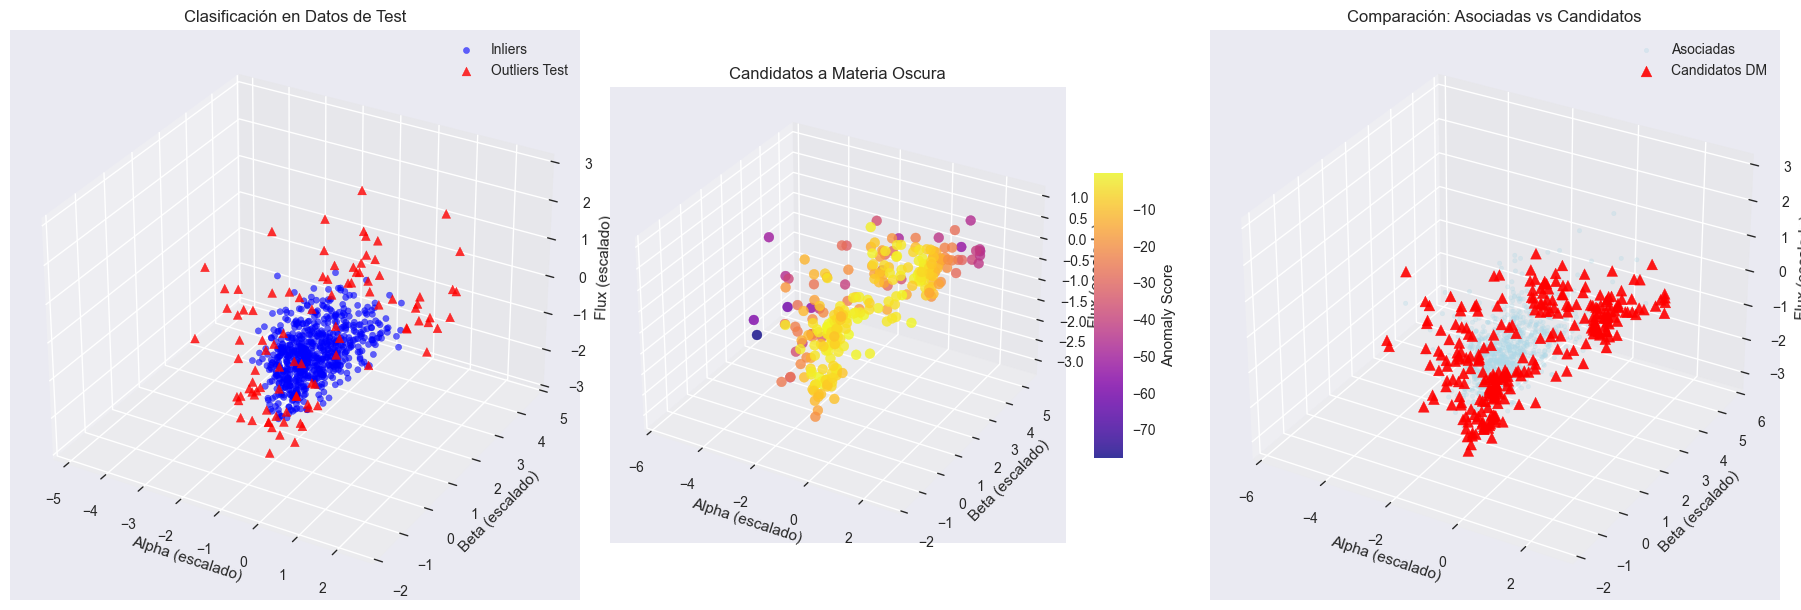

In [200]:
# Crear figura con subplots 3D
fig = plt.figure(figsize=(18, 6))

# Plot 1: Clasificación en datos de test
ax1 = fig.add_subplot(131, projection='3d')

# Separar inliers y outliers en test
inliers_mask = test_preds == 1
outliers_mask = test_preds == -1

scatter1 = ax1.scatter(X_test_scaled[inliers_mask, 0], 
                      X_test_scaled[inliers_mask, 1], 
                      X_test_scaled[inliers_mask, 2], 
                      c='blue', alpha=0.6, label='Inliers', s=20)

scatter2 = ax1.scatter(X_test_scaled[outliers_mask, 0], 
                      X_test_scaled[outliers_mask, 1], 
                      X_test_scaled[outliers_mask, 2], 
                      c='red', alpha=0.8, label='Outliers Test', s=40, marker='^')

ax1.set_xlabel('Alpha (escalado)')
ax1.set_ylabel('Beta (escalado)')
ax1.set_zlabel('Flux (escalado)')
ax1.set_title('Clasificación en Datos de Test')
ax1.legend()

# Plot 2: Candidatos a materia oscura
ax2 = fig.add_subplot(132, projection='3d')

if len(candidates) > 0:
    # Escalar candidatos para visualización
    candidates_features = candidates[['alpha', 'beta', 'flux']].values
    candidates_scaled = scaler.transform(candidates_features)
    
    scatter3 = ax2.scatter(candidates_scaled[:, 0], 
                          candidates_scaled[:, 1], 
                          candidates_scaled[:, 2], 
                          c=candidates['anomaly_score'], 
                          cmap='plasma', alpha=0.8, s=50)
    
    plt.colorbar(scatter3, ax=ax2, shrink=0.5, aspect=10, label='Anomaly Score')

ax2.set_xlabel('Alpha (escalado)')
ax2.set_ylabel('Beta (escalado)')
ax2.set_zlabel('Flux (escalado)')
ax2.set_title('Candidatos a Materia Oscura')

# Plot 3: Comparación general
ax3 = fig.add_subplot(133, projection='3d')

# Muestra representativa de fuentes asociadas
sample_size = min(1000, len(X_train_scaled))
sample_indices = np.random.choice(len(X_train_scaled), sample_size, replace=False)
sample_associated = X_train_scaled[sample_indices]

scatter4 = ax3.scatter(sample_associated[:, 0], 
                      sample_associated[:, 1], 
                      sample_associated[:, 2], 
                      c='lightblue', alpha=0.3, label='Asociadas', s=10)

# Candidatos anómalos
if len(candidates) > 0:
    scatter5 = ax3.scatter(candidates_scaled[:, 0], 
                          candidates_scaled[:, 1], 
                          candidates_scaled[:, 2], 
                          c='red', alpha=0.9, label='Candidatos DM', s=60, marker='^')

ax3.set_xlabel('Alpha (escalado)')
ax3.set_ylabel('Beta (escalado)')
ax3.set_zlabel('Flux (escalado)')
ax3.set_title('Comparación: Asociadas vs Candidatos')
ax3.legend()

plt.tight_layout()
plt.show()